In [1]:
import random
import math
import pandas as pd

In [2]:
def read_fasta(name):
    try:
        f = open(name,'r')
        l = f.readlines()
        del l[0]
        return(l)
    except IOError:
        return(0)

In [3]:
def read_txt(name):
    try:
        f = open(name,'r')
        l = f.readlines()
        return(l)
    except IOError:
        return(0)

In [4]:
def gff_file(name, genome):
    try:
        f = open(name,'r')
        l = f.readlines()
        l_conv = []
        for e in l:       
            orf = e.split()        
            pi = int(orf[3]); pf = int(orf[4])
            if orf[2] == 'single-exon':
                sf = genome[pf - 3:pf]
                l_conv.append(['ATG', pi - 2, sf, pf - 3]) 
            if orf[2] == 'initial-exon':
                l_conv.append(['ATG', pi - 2, 'GT', pf - 1])
            if orf[2] == 'internal-exon':
                l_conv.append(['AG', pi - 3, 'GT', pf - 1])  
            if orf[2] == 'final-exon':
                sf = genome[pf - 3:pf]
                l_conv.append(['AG', pi - 3, sf, pf - 3])
        return(l_conv)
    except IOError:
        return(0)

In [5]:
def dictionary(l):
    d = {}
    for e in l:       
        l_aux = e.split()
        d[l_aux[0]] = float(l_aux[1])
    return (d)

In [6]:
def look_s (gaux, s):
    l = []
    lenght = len(s)
    p = gaux.find(s)
    paux = 0
    while len(gaux) != 0 and p != -1:
        l.append(p + paux)
        gaux = gaux[p + lenght:]
        paux = paux + p + lenght
        p = gaux.find(s)
    return(l)

In [7]:
def get_pos(genome):
    l_ATG = look_s(genome, 'ATG')
    l_AG = look_s(genome, 'AG')
    l_GT = look_s(genome, 'GT')
    l_TAA = look_s(genome, 'TAA')
    l_TAG = look_s(genome, 'TAG')
    l_TGA = look_s(genome, 'TGA')
    return(l_ATG, l_AG, l_GT, l_TAA, l_TAG, l_TGA)

In [8]:
def ORF (l, genome):
    l_signals_i = ['ATG', 'AG']
    l_signals_f = ['GT', 'TAA', 'TAG', 'TGA']
    l_stop = ['TAA', 'TAG', 'TGA']
    l_pos_i = l[0:2]
    l_pos_f = l[2:6]
    l_orf = []
    for i in range (0, len(l_signals_i)):
        s_i = l_signals_i[i]
        for p_i in l_pos_i[i]:
            for j in range (0,len(l_signals_f)):
                s_f = l_signals_f[j]
                for p_f in l_pos_f[j]:
                    if p_f - p_i + len(s_f) >= 10:
                        if s_f in l_stop:
                            cad_aux = genome[p_i:p_f]
                        else:
                            cad_aux = genome[p_i:p_f + 2]
                        if 'TAA'not in cad_aux and 'TAG' not in cad_aux and 'TGA' not in cad_aux:
                            l_orf.append([s_i, p_i, s_f, p_f])
    return(l_orf)

In [9]:
def over_random(l_orf_true):
    i = 0
    while i < len(l_orf_true) - 1:
        j = i + 1
        while j < len(l_orf_true):
            pi = l_orf_true[i][1]
            pf = l_orf_true[i][3]
            si = l_orf_true[j][1]
            sf = l_orf_true[j][3]
            if (pi <= si and si <= pf) or (pi <= sf and sf <= pf) or (si <= pi and pi <= sf) or (si <= pf and pf <= sf):
                if random.random() >= 0.5:
                    del l_orf_true[j]
                else:
                    l_orf_true[i] = l_orf_true[j]
                    del l_orf_true[j]
                    j = i + 1
            else:
                j = j + 1
        i = i + 1
    return(l_orf_true)

In [10]:
def overlap_GC(l_orf_true, genome):
    i = 0
    while i < len(l_orf_true) - 1:
        j = i + 1
        while j < len(l_orf_true):
            pi = l_orf_true[i][1]
            pf = l_orf_true[i][3]
            si = l_orf_true[j][1]
            sf = l_orf_true[j][3]
            if (pi <= si and si <= pf) or (pi <= sf and sf <= pf) or (si <= pi and pi <= sf) or (si <= pf and pf <= sf):
                cad1 = genome[pi+len(l_orf_true[i][0]):pf]
                cad2 = genome[si+len(l_orf_true[j][0]):sf]
                prop1 = (cad1.count('G') + cad1.count('C'))/(len(cad1))
                prop2 = (cad2.count('G') + cad2.count('C'))/(len(cad2))
                if prop1 >= prop2:
                    del l_orf_true[j]
                else:
                    l_orf_true[i] = l_orf_true[j]
                    del l_orf_true[j]
                    j = i + 1
            else:
                j = j + 1
        i = i + 1
    return(l_orf_true)

In [11]:
def calc_codon(cad, d):
    c_sum = 0
    for codon in d:
        if codon in cad:
            c_sum = c_sum + math.log10(d[codon])
    return (c_sum/(len(cad)//3))

In [12]:
def overlap_codon(l_orf_true, genome, dic_codon):
    i = 0
    while i < len(l_orf_true) - 1:
        j = i + 1
        while j < len(l_orf_true):
            pi = l_orf_true[i][1]
            pf = l_orf_true[i][3]
            si = l_orf_true[j][1]
            sf = l_orf_true[j][3]
            if (pi <= si and si <= pf) or (pi <= sf and sf <= pf) or (si <= pi and pi <= sf) or (si <= pf and pf <= sf):
                if len(l_orf_true[i][0]) == 3:
                    if len(l_orf_true[i][2]) == 2:
                        cad1 = genome[pi + len(l_orf_true[i][0]):pf + 2]
                    else:
                        cad1 = genome[pi + len(l_orf_true[i][0]):pf]
                else:
                    if len(l_orf_true[i][2]) == 2:
                        cad1 = genome[pi:pf + 2]
                    else:
                        cad1 = genome[pi:pf]
                if len(l_orf_true[j][0]) == 3:
                    if len(l_orf_true[j][2]) == 2:
                        cad2 = genome[si + len(l_orf_true[j][0]):sf + 2]
                    else:
                        cad2 = genome[si + len(l_orf_true[j][0]):sf]
                else:
                    if len(l_orf_true[j][2]) == 2:
                        cad2 = genome[si:sf + 2]
                    else:
                        cad2 = genome[si:sf]
                res1 = calc_codon(cad1,dic_codon)
                res2 = calc_codon(cad2,dic_codon)
                if res1 >= res2:
                    del l_orf_true[j]
                else:
                    l_orf_true[i] = l_orf_true[j]
                    del l_orf_true[j]
                    j = i + 1
            else:
                j = j + 1
        i = i + 1
    return(l_orf_true)

In [13]:
def conv_list(l):
    for i in range (0,len(l)):
        l[i] = l[i].split()
    return(l)

In [14]:
def calc(c,l):
    s_calc = 0
    for i in range(0, len(c)):
        if c[i] == 'A':
            s_calc = s_calc + math.log(float(l[i][0]))
        elif c[i] == 'C':
            s_calc = s_calc + math.log(float(l[i][1]))
        elif c[i] == 'G':
            s_calc = s_calc + math.log(float(l[i][2]))
        else:
            s_calc = s_calc + math.log(float(l[i][3]))
    return(s_calc)

In [15]:
def calc_WMM(orf):
    before = genome[orf[1] - 5:orf[1]]
    if orf[0] == 'ATG':
        before_calc = calc(before, l_START)
    else:
        before_calc = calc(before, l_ACCEPTOR)
    after = genome[orf[3] + len(orf[2]):orf[3] + len(orf[2]) + 5]
    if orf[2] == 'GT':
        after_calc = calc(after, l_DONOR)
    else:
        after_calc = calc(after, l_STOP)
    return(before_calc + after_calc)

In [16]:
def codon_WMM(l_orf_true, genome, dic_codon): 
    i = 0
    while i < len(l_orf_true) - 1:
        j = i + 1
        while j < len(l_orf_true):
            pi = l_orf_true[i][1]
            pf = l_orf_true[i][3]
            si = l_orf_true[j][1]
            sf = l_orf_true[j][3]
            if (pi <= si and si <= pf) or (pi <= sf and sf <= pf) or (si <= pi and pi <= sf) or (si <= pf and pf <= sf):
                if len(l_orf_true[i][0]) == 3:
                    if len(l_orf_true[i][2]) == 2:
                        cad1 = genome[pi + len(l_orf_true[i][0]):pf + 2]
                    else:
                        cad1 = genome[pi + len(l_orf_true[i][0]):pf]
                else:
                    if len(l_orf_true[i][2]) == 2:
                        cad1 = genome[pi:pf + 2]
                    else:
                        cad1 = genome[pi:pf]
                if len(l_orf_true[j][0]) == 3:
                    if len(l_orf_true[j][2]) == 2:
                        cad2 = genome[si + len(l_orf_true[j][0]):sf + 2]
                    else:
                        cad2 = genome[si + len(l_orf_true[j][0]):sf]
                else:
                    if len(l_orf_true[j][2]) == 2:
                        cad2 = genome[si:sf + 2]
                    else:
                        cad2 = genome[si:sf]
                res1 = calc_codon(cad1, dic_codon) + calc_WMM(l_orf_true[i])
                res2 = calc_codon(cad2, dic_codon) + calc_WMM(l_orf_true[j])
                if res1 >= res2:
                    del l_orf_true[j]
                else:
                    l_orf_true[i] = l_orf_true[j]
                    del l_orf_true[j]
                    j = i + 1
            else:
                j = j + 1
        i = i + 1
    return(l_orf_true)

In [17]:
def list_genome(genome, l_orfs):
    lg = [0] * len(genome)
    for i in l_orfs:
        if len(i[2]) == 3:
            pf = i[3] + 3
        else:
            pf = i[3] + 2
        if len(i[0]) == 3:
            pi = i[1]
        else:
            pi = i[1] + 2
        for e in range (pi, pf): 
            lg[e] = 1
    return(lg)

In [18]:
def calc_sp_FPR(l_r, l):
    tp = 0; tn = 0; fp = 0; fn = 0
    for i in range(0, len(l_r)):
        if l_r[i] == 1:
            if l[i] == 1:
                tp = tp + 1
            else:
                fn = fn + 1      
        else:
            if l[i] == 0:
                tn = tn + 1
            else:
                fp = fp + 1
    return((tp/(tp + fp)), (fp/(fp + tn)))

In [19]:
name_f = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/Gsimplicans.fasta'
file_lines = read_fasta(name_f)
if file_lines != 0:
    genome = ''.join(file_lines)
    genome = genome.replace('\n','')
    signals_list = get_pos(genome)
    l_ORF = ORF(signals_list, genome)
    l_ORF_1 = []
    l_ORF_2 = []
    l_ORF_3 = []
    l_ORF_4 = []
    for e in l_ORF:
        l_ORF_1.append(e)
        l_ORF_2.append(e)
        l_ORF_3.append(e)
        l_ORF_4.append(e)
    l_ORF_random = over_random(l_ORF_1)
    l_ORF_GC = overlap_GC(l_ORF_2, genome)
    name_c = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/codons.txt'
    c_lines=read_txt(name_c)
    if c_lines != 0:
        dic = dictionary(c_lines)
        l_ORF_codon = overlap_codon(l_ORF_3, genome, dic)
        name_a = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/acceptor.txt'
        l_ACCEPTOR = read_txt(name_a)
        name_d = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/donor.txt'
        l_DONOR = read_txt(name_d)
        name_s = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/start.txt'
        l_START = read_txt(name_s)
        name_t = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/stop.txt'
        l_STOP = read_txt(name_t)
        if l_ACCEPTOR != 0 and l_DONOR != 0 and l_START != 0 and l_STOP != 0:
            l_ACCEPTOR = conv_list(l_ACCEPTOR)
            l_DONOR = conv_list(l_DONOR)
            l_START = conv_list(l_START)
            l_STOP = conv_list(l_STOP)
            l_ORF_WMM = codon_WMM(l_ORF_4, genome, dic)
            name_gff = '/Volumes/TOSHIBA EXT/3r curs/1r quatri/Bioinformàtica I/Bioinformàtica amb Python/Pràctica/reals.gff'
            l_ORF_reals = gff_file(name_gff, genome)
            if l_ORF_reals != 0:
                lg_random = list_genome(genome, l_ORF_random)
                lg_GC = list_genome(genome, l_ORF_GC)
                lg_codon = list_genome(genome, l_ORF_codon)
                lg_WMM = list_genome(genome, l_ORF_WMM)
                lg_reals = list_genome(genome, l_ORF_reals)
                c_random = calc_sp_FPR(lg_reals, lg_random)
                c_GC = calc_sp_FPR(lg_reals, lg_GC)
                c_codon = calc_sp_FPR(lg_reals, lg_codon)
                c_WMM = calc_sp_FPR(lg_reals, lg_WMM)

In [20]:
lab = ['Random', 'GC', 'Codon usage', 'Weight matrix']
df = pd.DataFrame({'SPECIFICITY':[c_random[0], c_GC[0], c_codon[0], c_WMM[0]], 'FPR':[c_random[1], c_GC[1], c_codon[1], c_WMM[1]]}, index=lab)
print(df) 

               SPECIFICITY       FPR
Random            0.538732  0.527517
GC                0.588889  0.446980
Codon usage       0.561785  0.514094
Weight matrix     0.631974  0.460403


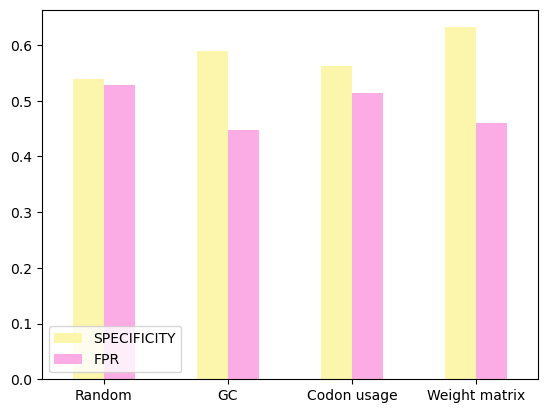

In [22]:
plt = df.plot.bar(rot = 0, color = {'SPECIFICITY':'#FCF5AC', 'FPR':'#FCACE5'})
plt.legend(loc = 'lower left')        